In [3]:
# Khai báo các thư viện cần thiết
from new_import import *

In [27]:
# Khai báo đường dẫn đến kết quả phân loại và kết quả thực tế của địa phương
KD_path = "ThuanHoa/KhoanhDat_new/ThuanHoa_TKDD2022.shp"
KetQuaPhanLoaiDat = "KetQuaPhanLoaiDat_15-09.tif"

In [3]:
gdf = gpd.read_file(KD_path, crs="EPSG:9209")

In [4]:
gdf.head(5)

,id,thuaid,xaid,shbando,shthua,dientich,maloaidat,khloaidat,diadanh,dtsd,tenchu,diachi,mdsd2003,kh2003,mscolor,shthuatam,dtthocu,geometry
0,0,7620220493,31576,202,493,5058.2,50,None,None,1,SKC,TKT,33,SKC,None,None,0,"POLYGON ((540179.700 1070550.084, 540209.964 1..."
1,1,7620220456,31576,202,456,407.6,53,None,None,1,ONT,GDC,26,ONT,None,None,0,"POLYGON ((540278.458 1070634.382, 540300.244 1..."
2,2,7620220465,31576,202,465,4537.2,-1,None,None,1,CLN,GDC,-1,None,None,None,0,"POLYGON ((540212.264 1070577.653, 540278.458 1..."
3,3,7620220451,31576,202,451,397.9,53,None,None,1,ONT,GDC,26,ONT,None,None,0,"POLYGON ((540315.403 1070666.044, 540325.424 1..."
4,4,7620220494,31576,202,494,3016.7,6,None,None,1,LUC,GDC,1,LUC,None,None,0,"POLYGON ((540301.202 1070519.021, 540315.563 1..."


In [5]:
gdf = gpd.read_file(KD_path, crs="EPSG:9209")

In [5]:
# khai báo các loại đất ứng với các mã đất phân loại được
CODE_MAP = {
    "BHK": 2,
    "CLN": 3,
    "DGD": 6,
    "DGT": 6,
    "DNL": 6,
    "DRA": 6,
    "DSH": 6,
    "DTL": 5,
    "DTS": 6,
    "DYT": 6,
    "LUC": 1,
    "NKH": 3,
    "NTD": 6,
    "NTS": 4,
    "ONT": 6,
    "SKC": 6,
    "SKX": 6,
    "SON": 5,
    "TMD": 6,
    "TON": 6,
    "TSC": 6,
}

label_mapping = {
    "Lua tom": 0,
    "Lua": 1,
    "Cay hang nam": 2,
    "Cay lau nam": 3,
    "Thuy san": 4,
    "Song": 5,
    "Dat xay dung": 6,
    "Rung": 7
}

tenchu_to_label_mapping = {
    "BHK": "Cay hang nam",   
    "CLN": "Cay lau nam",    
    "DGD": "Dat xay dung",   
    "DGT": "Dat xay dung",   
    "DNL": "Dat xay dung",   
    "DRA": "Dat xay dung",   
    "DSH": "Dat xay dung",   
    "DTL": "Song",           
    "DTS": "Dat xay dung",   
    "DYT": "Dat xay dung",   
    "LUC": "Lua",            
    "NKH": "Cay lau nam",    
    "NTD": "Dat xay dung",   
    "NTS": "Thuy san",       
    "ONT": "Dat xay dung",   
    "SKC": "Dat xay dung",   
    "SKX": "Dat xay dung",   
    "SON": "Song",           
    "TMD": "Dat xay dung",   
    "TON": "Dat xay dung",   
    "TSC": "Dat xay dung"    
}

# Khai báo các nhãn phân loại đất ứng với 3 loại đất chính
HT_MAP = {
    "NN": {"name": "Đất Nông Nghiệp", "data": [1, 2, 3, 4]},
    "PNN": {"name": "Đất Phi Nông Nghiệp", "data": [6]},
    "TQ": {"name": "Đất Thổ Quả", "data": [15]},
}

In [8]:
def test(KD_path, KetQuaPhanLoaiDat, CODE_MAP, label_mapping):
    gdf = gpd.read_file(KD_path, crs="EPSG:9209")
    polygons = gdf.geometry.values
    labels_before = gdf.tenchu.values
    output_image = rioxarray.open_rasterio(KetQuaPhanLoaiDat)
    
    array_list = []
    result = []  
    mapped_array_list = []  

    for i in range(len(polygons)):
        po = polygons[i]
        lb_before = labels_before[i]
        
        # Kiểm tra và gán "TQ" nếu có nhiều mã
        if ";" in lb_before:
            lb_before = "TQ"
        
        # Lấy mã từ CODE_MAP
        code_lb = CODE_MAP.get(lb_before, 15)
        
        try:
            qr = output_image.rio.clip([po], "EPSG:9209")
            changed_points = qr.where(qr != float(code_lb), np.nan)  

            # Kiểm tra có thay đổi không
            if changed_points.notnull().any():
                label_after_values = changed_points.values.flatten()

                for value in label_after_values:
                    if not np.isnan(value):
                        # Tìm label_after_key dựa trên value
                        label_after_key = next((key for key, val in label_mapping.items() if val == int(value)), None)
                        lb_mapped = tenchu_to_label_mapping.get(lb_before, None)
                        if lb_mapped is None:
                            print(f"Lỗi: Không tìm thấy ánh xạ cho nhãn '{lb_before}' trong tenchu_to_label_mapping.")
                            continue

                        result.append({
                            'label_before': lb_mapped,
                            'label_after': label_after_key
                        })
                        
                        mapped_array_list.append({
                            'image': changed_points,
                            'label_before': lb_mapped,
                            'label_after': label_after_key
                        })
                
                array_list.append(changed_points)  # Chỉ thêm vào array_list nếu có thay đổi
        except Exception as e:
            print(f"Lỗi xử lý polygon {i}: {e}")

    return array_list, result, mapped_array_list


In [9]:
# Tiến hành chồng lắp
array_list, result, mapped_array_list = test(KD_path, KetQuaPhanLoaiDat, CODE_MAP, label_mapping)

Lỗi xử lý polygon 113: No data found in bounds.
Lỗi xử lý polygon 548: No data found in bounds.
Lỗi xử lý polygon 729: No data found in bounds.


In [11]:
df = pd.DataFrame(result)
grouped_counts = df.groupby(['label_before', 'label_after']).size().reset_index(name='count')
total_count = len(df)


grouped_counts['percentage'] = grouped_counts['count'] / total_count

grouped_counts

,label_before,label_after,count,percentage
0,Cay hang nam,Cay lau nam,2028,0.048335
1,Cay hang nam,Dat xay dung,92,0.002193
2,Cay hang nam,Lua,1368,0.032605
3,Cay hang nam,Rung,559,0.013323
4,Cay hang nam,Thuy san,1,0.000024
5,Cay lau nam,Cay hang nam,2478,0.059060
6,Cay lau nam,Dat xay dung,3121,0.074386
7,Cay lau nam,Lua,2560,0.061015
8,Cay lau nam,Lua tom,6,0.000143
9,Cay lau nam,Rung,1817,0.043306


In [12]:
filtered_counts = grouped_counts[grouped_counts['count'] >= 100].reset_index(drop=True)
filtered_counts

,label_before,label_after,count,percentage
0,Cay hang nam,Cay lau nam,2028,0.048335
1,Cay hang nam,Lua,1368,0.032605
2,Cay hang nam,Rung,559,0.013323
3,Cay lau nam,Cay hang nam,2478,0.059060
4,Cay lau nam,Dat xay dung,3121,0.074386
5,Cay lau nam,Lua,2560,0.061015
6,Cay lau nam,Rung,1817,0.043306
7,Dat xay dung,Cay hang nam,1957,0.046643
8,Dat xay dung,Cay lau nam,3414,0.081369
9,Dat xay dung,Lua,2815,0.067092


In [13]:
sankey_data = [['From', 'To', 'Weight']] + [
    [row['label_before'], row['label_after'], row['count']]
    for _, row in filtered_counts.iterrows()
]

sankey_data

[['From', 'To', 'Weight'],
 ['Cay hang nam', 'Cay lau nam', 2028],
 ['Cay hang nam', 'Lua', 1368],
 ['Cay hang nam', 'Rung', 559],
 ['Cay lau nam', 'Cay hang nam', 2478],
 ['Cay lau nam', 'Dat xay dung', 3121],
 ['Cay lau nam', 'Lua', 2560],
 ['Cay lau nam', 'Rung', 1817],
 ['Dat xay dung', 'Cay hang nam', 1957],
 ['Dat xay dung', 'Cay lau nam', 3414],
 ['Dat xay dung', 'Lua', 2815],
 ['Dat xay dung', 'Rung', 1414],
 ['Lua', 'Cay hang nam', 1645],
 ['Lua', 'Cay lau nam', 4674],
 ['Lua', 'Dat xay dung', 231],
 ['Lua', 'Rung', 780],
 ['Song', 'Cay hang nam', 2167],
 ['Song', 'Cay lau nam', 3531],
 ['Song', 'Dat xay dung', 641],
 ['Song', 'Lua', 2530],
 ['Song', 'Rung', 876],
 ['Thuy san', 'Cay hang nam', 215],
 ['Thuy san', 'Cay lau nam', 334],
 ['Thuy san', 'Lua', 436]]

In [ ]:
mapped_array_list

In [11]:
rs = merge_arrays(array_list, nodata = np.nan)

In [12]:
rs

<xarray.DataArray (band: 1, y: 484, x: 791)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 5.952e+05 5.952e+05 ... 6.031e+05 6.031e+05
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

In [13]:
save_path = "ThuanHoa/KetQuaMoi"

In [14]:
if not os.path.exists(save_path):
        os.mkdir(save_path)
rs.rio.to_raster(f"{save_path}/ChongLap_test.tif")
print(f"save {save_path}/ChongLap_test.tif")

save ThuanHoa/KetQuaMoi/ChongLap_test.tif


In [15]:
# cấu hình màu cho các loại đất
colors = [
    "#abcee9",
    "#ffef44",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]

/tmp/ipykernel_194/1556837544.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


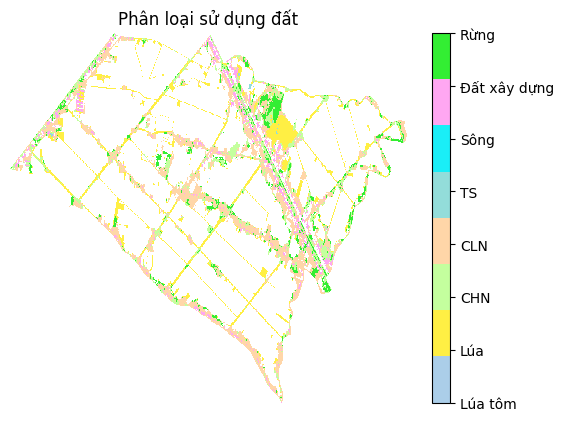

In [16]:
# hiển thị phân loại sử dụng đất
cmap = ListedColormap(colors)
img = rs.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

In [15]:
gdf = gpd.read_file(KD_path, crs="EPSG:9209")

filtered_counts = gpd.GeoDataFrame(filtered_counts, geometry=gdf.geometry, crs=gdf.crs)

output_path = "output/labeled_result.shp"
filtered_counts.to_file(output_path)

print(f"Shapefile đã được lưu tại: {output_path}")

Shapefile đã được lưu tại: output/labeled_result.shp


/tmp/ipykernel_107/3878420892.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  filtered_counts.to_file(output_path)


In [16]:
output = gpd.read_file("output/labeled_result.shp", crs="EPSG:9209")

In [17]:
output

,label_befo,label_afte,count,percentage,geometry
0,Cay hang nam,Cay lau nam,2028,0.048335,"POLYGON ((540179.700 1070550.084, 540209.964 1..."
1,Cay hang nam,Lua,1368,0.032605,"POLYGON ((540278.458 1070634.382, 540300.244 1..."
2,Cay hang nam,Rung,559,0.013323,"POLYGON ((540212.264 1070577.653, 540278.458 1..."
3,Cay lau nam,Cay hang nam,2478,0.059060,"POLYGON ((540315.403 1070666.044, 540325.424 1..."
4,Cay lau nam,Dat xay dung,3121,0.074386,"POLYGON ((540301.202 1070519.021, 540315.563 1..."
5,Cay lau nam,Lua,2560,0.061015,"POLYGON ((540325.424 1070674.633, 540340.356 1..."
6,Cay lau nam,Rung,1817,0.043306,"POLYGON ((540297.974 1070574.813, 540300.514 1..."
7,Dat xay dung,Cay hang nam,1957,0.046643,"POLYGON ((540340.356 1070687.429, 540344.227 1..."
8,Dat xay dung,Cay lau nam,3414,0.081369,"POLYGON ((540327.344 1070601.823, 540327.234 1..."
9,Dat xay dung,Lua,2815,0.067092,"POLYGON ((540344.227 1070690.747, 540416.194 1..."


In [24]:
def test2(KD_path, KetQuaPhanLoaiDat, CODE_MAP, label_mapping, tenchu_to_label_mapping, output_shapefile):
    # Đọc shapefile
    gdf = gpd.read_file(KD_path, crs="EPSG:9209")
    polygons = gdf.geometry.values
    labels_before = gdf.tenchu.values
    output_image = rioxarray.open_rasterio(KetQuaPhanLoaiDat)
    
    result_data = []

    for i in range(len(polygons)):
        po = polygons[i]
        lb_before = labels_before[i]
        
        # Kiểm tra và gán "TQ" nếu có nhiều mã
        if ";" in lb_before:
            lb_before = "TQ"
        
        # Chuyển nhãn từ 'BHK', 'CLN', ... sang nhãn trong `label_mapping`
        lb_mapped = tenchu_to_label_mapping.get(lb_before, None)
        if lb_mapped is None:
            print(f"Lỗi: Không tìm thấy ánh xạ cho nhãn '{lb_before}' trong tenchu_to_label_mapping.")
            lb_mapped = "Unknown"
        
        # Lấy mã từ label_mapping
        code_lb = label_mapping.get(lb_mapped, 15)
        
        try:
            qr = output_image.rio.clip([po], "EPSG:9209")
            changed_points = qr.where(qr != float(code_lb), np.nan)  

            # Kiểm tra có thay đổi không
            if changed_points.notnull().any():
                label_after_values = changed_points.values.flatten()
                label_after_set = set(value for value in label_after_values if not np.isnan(value))
                label_after_names = [
                    next((key for key, val in label_mapping.items() if val == int(value)), None)
                    for value in label_after_set
                ]

                # Lưu nhãn trước và nhãn sau
                result_data.append({
                    "geometry": po,
                    "label_before": lb_mapped,
                    "label_after": "; ".join(filter(None, label_after_names))
                })
            else:
                # Nếu không có thay đổi
                result_data.append({
                    "geometry": po,
                    "label_before": lb_mapped,
                    "label_after": lb_mapped  # Không thay đổi
                })
        except Exception as e:
            print(f"Lỗi xử lý polygon {i}: {e}")
            result_data.append({
                "geometry": po,
                "label_before": lb_mapped,
                "label_after": "Error"
            })

    # Chuyển đổi dữ liệu kết quả thành GeoDataFrame
    result_gdf = gpd.GeoDataFrame(result_data, crs="EPSG:9209")

    # Lưu shapefile
    result_gdf.to_file(output_shapefile, driver="ESRI Shapefile")
    print(f"Shapefile kết quả đã được lưu tại: {output_shapefile}")

    return result_gdf


In [29]:
output_shapefile = "output/test2_output_result.shp"

result_gdf = test2(KD_path, KetQuaPhanLoaiDat, CODE_MAP, label_mapping, tenchu_to_label_mapping, output_shapefile)

# Kiểm tra dữ liệu kết quả
result_gdf.head(5)


Lỗi xử lý polygon 113: No data found in bounds.
Lỗi xử lý polygon 548: No data found in bounds.
Lỗi xử lý polygon 729: No data found in bounds.


/tmp/ipykernel_107/1438382411.py:65: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result_gdf.to_file(output_shapefile, driver="ESRI Shapefile")


Shapefile kết quả đã được lưu tại: output/test2_output_result.shp


,geometry,label_before,label_after
0,"POLYGON ((540179.700 1070550.084, 540209.964 1...",Dat xay dung,Lua; Cay hang nam; Cay lau nam
1,"POLYGON ((540278.458 1070634.382, 540300.244 1...",Dat xay dung,Cay lau nam
2,"POLYGON ((540212.264 1070577.653, 540278.458 1...",Cay lau nam,Cay hang nam; Dat xay dung; Rung
3,"POLYGON ((540315.403 1070666.044, 540325.424 1...",Dat xay dung,Cay lau nam
4,"POLYGON ((540301.202 1070519.021, 540315.563 1...",Lua,Cay lau nam; Rung


In [31]:
result_gdf

,geometry,label_before,label_after
0,"POLYGON ((540179.700 1070550.084, 540209.964 1...",Dat xay dung,Lua; Cay hang nam; Cay lau nam
1,"POLYGON ((540278.458 1070634.382, 540300.244 1...",Dat xay dung,Cay lau nam
2,"POLYGON ((540212.264 1070577.653, 540278.458 1...",Cay lau nam,Cay hang nam; Dat xay dung; Rung
3,"POLYGON ((540315.403 1070666.044, 540325.424 1...",Dat xay dung,Cay lau nam
4,"POLYGON ((540301.202 1070519.021, 540315.563 1...",Lua,Cay lau nam; Rung
5,"POLYGON ((540325.424 1070674.633, 540340.356 1...",Cay lau nam,Dat xay dung
6,"POLYGON ((540297.974 1070574.813, 540300.514 1...",Cay hang nam,Cay lau nam; Rung
7,"POLYGON ((540340.356 1070687.429, 540344.227 1...",Dat xay dung,Cay lau nam
8,"POLYGON ((540327.344 1070601.823, 540327.234 1...",Cay lau nam,Dat xay dung
9,"POLYGON ((540344.227 1070690.747, 540416.194 1...",Cay lau nam,Cay hang nam; Dat xay dung
